## Imports

In [14]:
# Imports

import pandas as pd
import numpy as np
import acquire
import prepare
from statistics import mean



import re
import unicodedata
import pandas as pd
import nltk

import prepare
import acquire

from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud


%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns



## Call In DF

In [2]:
df = acquire.get_github_geology_results(cached=True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1841 entries, 0 to 1840
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   language  1841 non-null   object        
 1   content   1841 non-null   object        
 2   date      1841 non-null   datetime64[ns]
dtypes: datetime64[ns](1), object(2)
memory usage: 57.5+ KB
None


,language,content,date
0,Jupyter Notebook,hylite\nhylite is an open-source python packag...,2020-11-27 17:31:07.762
1,Python,\n\n\n\n\n\nWebviz subsurface\n\n✨👓 Live demo ...,2020-11-27 17:31:08.305
2,R,"Reforester\nReforester, an R program that:\n\n...",2020-11-27 17:31:08.926
3,JavaScript,Swissgeol NGM\nA Geology 3D viewer\nSwissgeol ...,2020-11-27 17:31:09.532
4,Python,geomodel-2-3dweb\n\nGenerates 3D web versions ...,2020-11-27 17:31:10.206


In [3]:
df.language.value_counts()

Python              463
Jupyter Notebook    460
R                   232
JavaScript          229
TypeScript          229
Batchfile           228
Name: language, dtype: int64

In [4]:
#Clean
df = prepare.prep_data(df, 'content', extra_words=[], exclude_words=[])
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1841 entries, 0 to 1840
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   language    1841 non-null   object        
 1   content     1841 non-null   object        
 2   date        1841 non-null   datetime64[ns]
 3   clean       1841 non-null   object        
 4   stemmed     1841 non-null   object        
 5   lemmatized  1841 non-null   object        
 6   words       1841 non-null   object        
 7   doc_length  1841 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 129.4+ KB
None


,language,content,date,clean,stemmed,lemmatized,words,doc_length
0,Jupyter Notebook,hylite\nhylite is an open-source python packag...,2020-11-27 17:31:07.762,hylite hylite opensource python package prepro...,hylit hylit opensourc python packag preprocess...,hylite hylite opensource python package prepro...,"[hylite, hylite, opensource, python, package, ...",300
1,Python,\n\n\n\n\n\nWebviz subsurface\n\n✨👓 Live demo ...,2020-11-27 17:31:08.305,webviz subsurface live demo application introd...,webviz subsurfac live demo applic introduct re...,webviz subsurface live demo application introd...,"[webviz, subsurface, live, demo, application, ...",261
2,R,"Reforester\nReforester, an R program that:\n\n...",2020-11-27 17:31:08.926,reforester reforester r program uses logistic ...,reforest reforest r program use logist birthde...,reforester reforester r program us logistic bi...,"[reforester, reforesterprogram, us, logistic, ...",777
3,JavaScript,Swissgeol NGM\nA Geology 3D viewer\nSwissgeol ...,2020-11-27 17:31:09.532,swissgeol ngm geology 3d viewer swissgeol new ...,swissgeol ngm geolog 3d viewer swissgeol new g...,swissgeol ngm geology 3d viewer swissgeol new ...,"[swissgeol, ngm, geology, 3d, viewer, swissgeo...",127
4,Python,geomodel-2-3dweb\n\nGenerates 3D web versions ...,2020-11-27 17:31:10.206,geomodel23dweb generates 3d web versions geolo...,geomodel23dweb gener 3d web version geolog mod...,geomodel23dweb generates 3d web version geolog...,"[geomodel23dweb, generates, 3d, web, version, ...",173


In [5]:
df.language.value_counts()

Python              463
Jupyter Notebook    460
R                   232
JavaScript          229
TypeScript          229
Batchfile           228
Name: language, dtype: int64

## Ave Length of Readme

In [13]:
python_doc_length = round(mean(df[df.language == 'Python'].doc_length), 2)
jupyter_doc_length = round(mean(df[df.language == 'Jupyter Notebook'].doc_length),2)
r_doc_length = round(mean(df[df.language == 'R'].doc_length),2)
javascript_doc_length = round(mean(df[df.language == 'JavaScript'].doc_length),2)
typescript_doc_length = round(mean(df[df.language == 'TypeScript'].doc_length),2)
batchfile_doc_length = round(mean(df[df.language == 'Batchfile'].doc_length),2)

print(f'The average word length of the python repositories is {python_doc_length}')
print(f'The average word length of the jupyter repositories is {jupyter_doc_length}')
print(f'The average word length of the r repositories is {r_doc_length}')
print(f'The average word length of the javascript repositories is {javascript_doc_length}')
print(f'The average word length of the typescript repositories is {typescript_doc_length}')
print(f'The average word length of the batchfile repositories is {batchfile_doc_length}')

The average word length of the python repositories is 217.1
The average word length of the jupyter repositories is 174.1
The average word length of the r repositories is 777
The average word length of the javascript repositories is 127
The average word length of the typescript repositories is 296
The average word length of the batchfile repositories is 307


## Explore List of Words

In [16]:
# Create list of words
python_words = ' '.join(df[df.language=='Python'].lemmatized)
jupyter_words = ' '.join(df[df.language=='Jupyter Notebook'].lemmatized)
r_words = ' '.join(df[df.language=='R'].lemmatized)
typescript_words = ' '.join(df[df.language=='TypeScript'].lemmatized)
javascript_words = ' '.join(df[df.language=='JavaScript'].lemmatized)
batchfile_words = ' '.join(df[df.language=='Batchfile'].lemmatized)
all_words = ' '.join(df.lemmatized)

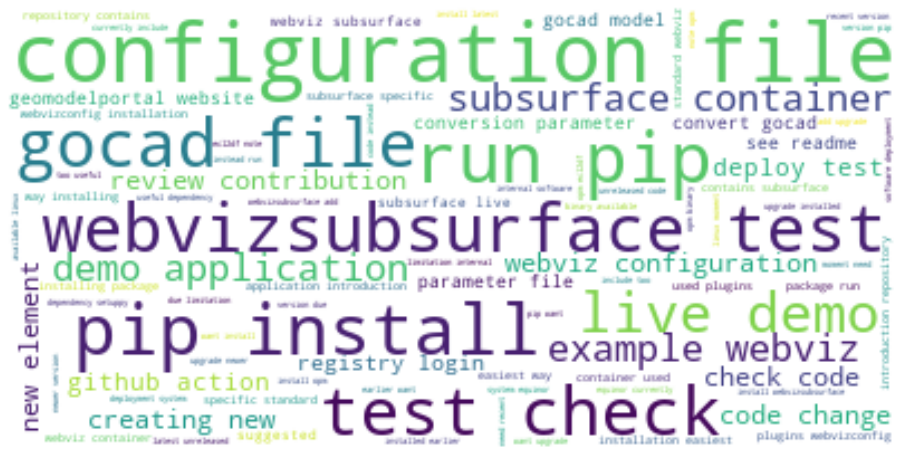

In [22]:
# Wordcloud python
plt.figure(figsize=(16,10))
text = python_words
wc = WordCloud(background_color="white",
               max_words=2000, max_font_size=224,
               random_state=42)
wc.generate(text)
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()

## Bigrams and Trigrams

In [ ]:
#Create list of bigrams
ham_bigrams = pd.Series(list(nltk.ngrams(ham_words.split(), 2))).value_counts().hea